Optimal Number of Clusters: 10
Davies-Bouldin Index for Optimal Clustering: 0.874354292939002


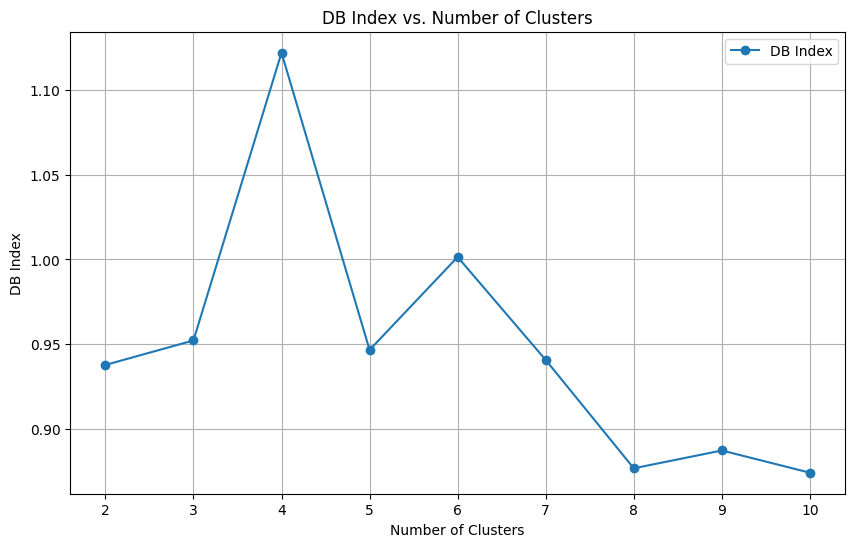

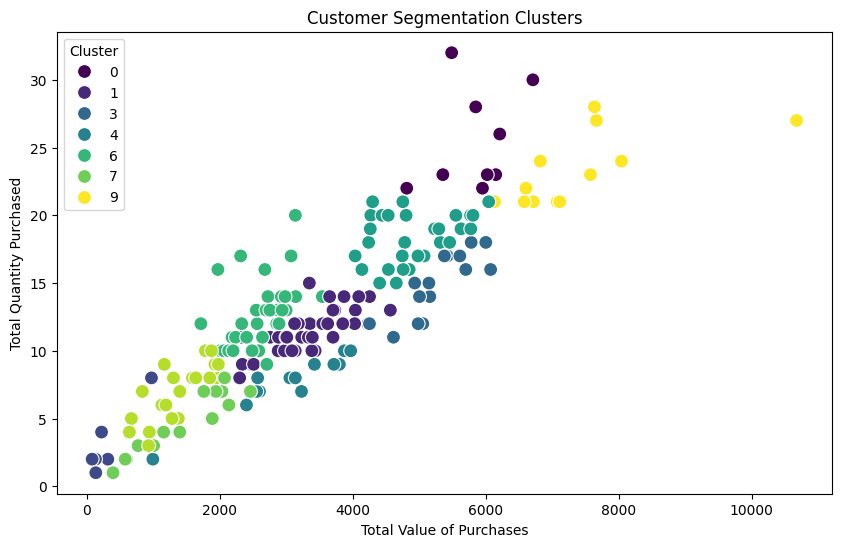

Number of Clusters Formed: 10
Cluster Centers (scaled features):
[[ 2.06919130e+00  1.29693736e+00 -5.13741271e-01]
 [-1.94946690e-01 -8.39021811e-02  2.64925413e-01]
 [-1.56172163e+00 -1.72624979e+00 -2.53576152e+00]
 [ 2.99807001e-01  9.08563008e-01  1.16077344e+00]
 [-8.17429754e-01 -2.56418533e-01  1.69879604e+00]
 [ 8.99331072e-01  7.88252262e-01 -1.59087130e-01]
 [ 1.43947771e-03 -4.66492044e-01 -8.14883151e-01]
 [-1.34441013e+00 -1.14329959e+00  5.70760581e-01]
 [-9.08606100e-01 -1.10451639e+00 -9.23308053e-01]
 [ 1.72511476e+00  2.14311603e+00  6.93638298e-01]]


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv(r"C:\Users\hai\Downloads\Customers.csv")
transactions = pd.read_csv(r"C:\Users\hai\Downloads\Transactions.csv")

# Merge the data (Customers and Transactions)
data = pd.merge(transactions, customers, on='CustomerID', how='inner')

# Feature Engineering: Aggregate transaction data by CustomerID
customer_features = data.groupby("CustomerID").agg({
    "Quantity": "sum",        # Total quantity purchased by the customer
    "TotalValue": "sum",      # Total amount spent by the customer
    "Price": "mean",          # Average price of products purchased
}).reset_index()

# Normalize the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['Quantity', 'TotalValue', 'Price']])

# Optimal clustering between 2 and 10 clusters
results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    silhouette_avg = silhouette_score(scaled_features, labels)
    results.append({
        "n_clusters": n_clusters,
        "db_index": db_index,
        "silhouette_score": silhouette_avg
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Select the optimal number of clusters (lowest DB Index)
optimal_clusters = results_df.loc[results_df['db_index'].idxmin(), 'n_clusters']
print(f"Optimal Number of Clusters: {optimal_clusters}")

# Final K-Means Clustering using optimal clusters
kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Evaluate the clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f"Davies-Bouldin Index for Optimal Clustering: {db_index}")

# Visualize DB Index vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_clusters'], results_df['db_index'], marker='o', label='DB Index')
plt.title("DB Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.legend()
plt.grid()
plt.show()

# Visualize the clusters (2D Scatter)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features['TotalValue'],
    y=customer_features['Quantity'],
    hue=customer_features['Cluster'],
    palette="viridis",
    s=100
)
plt.title("Customer Segmentation Clusters")
plt.xlabel("Total Value of Purchases")
plt.ylabel("Total Quantity Purchased")
plt.legend(title="Cluster")
plt.show()

# Output the number of clusters formed
num_clusters = len(customer_features['Cluster'].unique())
print(f"Number of Clusters Formed: {num_clusters}")

# Output the cluster centers (centroids)
print("Cluster Centers (scaled features):")
print(kmeans.cluster_centers_)

# Save results to CSV
customer_features.to_csv("Customer_Segmentation.csv", index=False)
